## Accessing GBIF data with the Planetary Computer STAC API

This notebook provides an example of accessing [Global Biodiversity Information Facility](https://planetarycomputer.microsoft.com/dataset/gbif) (GBIF) occurrence data from the Planetary Computer STAC API. Periodic snapshots of the data are stored in Parquet format.

In [8]:
import pystac_client
import planetary_computer

To access the data stored in Azure Blob Storage, we'll use the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs). 

In [1]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace    
)
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
list(items)

['gbif-2022-03-01',
 'gbif-2022-02-01',
 'gbif-2022-01-01',
 'gbif-2021-12-01',
 'gbif-2021-11-01',
 'gbif-2021-10-01',
 'gbif-2021-09-01',
 'gbif-2021-08-01',
 'gbif-2021-07-01',
 'gbif-2021-06-01',
 'gbif-2021-04-13']

https://sasweb.microsoft.com/Member/Silo/16477We'll take the most recent item.

In [2]:
item = list(items.values())[0]
item

<Item id=gbif-2022-03-01>

We'll use [Dask](https://docs.dask.org/en/latest/) to read the partitioned Parquet Dataset.

In [3]:
import dask.dataframe as dd

asset = item.assets["data"]
df = dd.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
    parquet_file_extension=None,
)
df

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,infraspecificepithet,taxonrank,scientificname,verbatimscientificname,verbatimscientificnameauthorship,countrycode,locality,stateprovince,occurrencestatus,individualcount,publishingorgkey,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,coordinateprecision,elevation,elevationaccuracy,depth,depthaccuracy,eventdate,day,month,year,taxonkey,specieskey,basisofrecord,institutioncode,collectioncode,catalognumber,recordnumber,identifiedby,dateidentified,license,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
npartitions=1105,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,object,int32,int32,int32,int32,int32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


As indicated by `npartitions`, this Parquet dataset is made up of many individual parquet files. We can read in a specific partition with `.get_partition`

In [4]:
chunk = df.get_partition(0).compute()
chunk

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,...,identifiedby,dateidentified,license,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,2434528850,4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4,0002cac3-f34d-4150-a255-2fbae15fa88d,Plantae,Tracheophyta,Liliopsida,Poales,Poaceae,Cymbopogon,Cymbopogon bombycinus,...,"Simon, B.K.",1986-01-01T00:00:00,CC_BY_4_0,Royal Botanic Gardens Board,"Dietrich, A.",None,None,2022-02-15T20:42:05.490Z,[],"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]"
1,2434529777,4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4,0007f5be-ff59-4744-8e18-9abe6a8dad62,Plantae,Tracheophyta,Magnoliopsida,Lamiales,Scrophulariaceae,Eremophila,Eremophila elderi,...,"Chinnock, R.J.",1994-06-23T00:00:00,CC_BY_4_0,Royal Botanic Gardens Board,"Tate, R.",None,None,2022-02-15T20:42:05.496Z,[],"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]"
2,2434529745,4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4,000a1936-3008-44f5-813f-a6c3469416bb,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Carex,Carex chlorantha,...,"Willis, J.H.",1949-08-01T00:00:00,CC_BY_4_0,Royal Botanic Gardens Board,"Robbins, F.",None,None,2022-02-15T20:42:05.504Z,[],"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]"
3,2434529880,4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4,000cc9b9-a730-4b28-accc-d8f9943acaea,Plantae,Bryophyta,Bryopsida,Bryales,Bartramiaceae,Philonotis,Philonotis tenuis,...,"Stone, I.G.",None,CC_BY_4_0,Royal Botanic Gardens Board,"Stone, I.G.",None,None,2022-02-15T20:42:05.509Z,[],"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]"
4,2434529956,4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4,000ebd11-5641-4f51-af20-fe65b88a2307,Plantae,Tracheophyta,Magnoliopsida,Asterales,Asteraceae,Senecio,Senecio pinnatifolius,...,"Thompson, I.R.",2005-06-07T00:00:00,CC_BY_4_0,Royal Botanic Gardens Board,"Finley, C.D.",None,None,2022-02-15T20:42:05.515Z,[],"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487797,3474245978,40e69efe-e113-4eea-9363-0a8eec54cf38,121ca327-f397-49f6-9e9b-24592d2fd07a,Animalia,Chordata,Aves,Anseriformes,Anatidae,Aythya,Aythya ferina,...,None,None,CC_BY_4_0,None,(),None,None,2022-02-22T19:38:06.595Z,[],"[RECORDED_DATE_INVALID, GEODETIC_DATUM_ASSUMED..."
1487798,3474047766,40e69efe-e113-4eea-9363-0a8eec54cf38,0cdf4b41-ed02-4f49-91e0-1a982286ad89,Animalia,Chordata,Aves,Charadriiformes,Haematopodidae,Haematopus,Haematopus ostralegus,...,None,None,CC_BY_4_0,None,(),None,None,2022-02-22T19:38:00.459Z,[],"[RECORDED_DATE_INVALID, GEODETIC_DATUM_ASSUMED..."
1487799,3474245982,40e69efe-e113-4eea-9363-0a8eec54cf38,122b4c1a-6448-4f0a-87ed-192dbb3993e5,Animalia,Chordata,Aves,Anseriformes,Anatidae,Tadorna,Tadorna tadorna,...,None,None,CC_BY_4_0,None,(),None,None,2022-02-22T19:38:06.595Z,[],"[RECORDED_DATE_INVALID, GEODETIC_DATUM_ASSUMED..."
1487800,3474047770,40e69efe-e113-4eea-9363-0a8eec54cf38,0d0cc2bf-770c-41b5-b166-8c9a3919f441,Animalia,Chordata,Aves,Anseriformes,Anatidae,Anas,Anas clypeata,...,None,None,CC_BY_4_0,None,(),None,None,2022-02-22T19:38:00.460Z,[],"[RECORDED_DATE_INVALID, GEODETIC_DATUM_ASSUMED..."


To get a sense for the most commonly observed species, we'll group the dataset and get the count of each species.

In [5]:
chunk.groupby(["kingdom", "phylum", "class", "family", "genus"])[
    "species"
].value_counts().sort_values(ascending=False).head(15)

kingdom   phylum      class           family           genus         species                 
Animalia  Arthropoda  Arachnida       Lycosidae        Trochosa      Trochosa terricola          6601
                                                       Pardosa       Pardosa pullata             6396
                      Insecta         Nymphalidae      Aglais        Aglais urticae              6246
                                      Pieridae         Gonepteryx    Gonepteryx rhamni           6223
                      Arachnida       Linyphiidae      Erigone       Erigone atra                5914
                      Insecta         Calopterygidae   Calopteryx    Calopteryx virgo            5692
          Chordata    Actinopterygii  Scombridae       Katsuwonus    Katsuwonus pelamis          5425
          Arthropoda  Insecta         Coenagrionidae   Ischnura      Ischnura elegans            5315
                      Arachnida       Lycosidae        Piratula      Piratula hygrophila  

Let's create a map with the number of unique species per country. First, we'll group by country code and compute the number of unique species (per country).

In [6]:
species_per_country = chunk.groupby("countrycode").species.nunique()
species_per_country

countrycode
AD      0
AE      1
AF      2
AG      0
AL      1
     ... 
YE     14
YT     11
ZA    116
ZM      2
ZW     12
Name: species, Length: 204, dtype: int64

Finally, we can plot the counts on a map using geopandas, by joining `species_per_country` to a dataset with country boundaries.

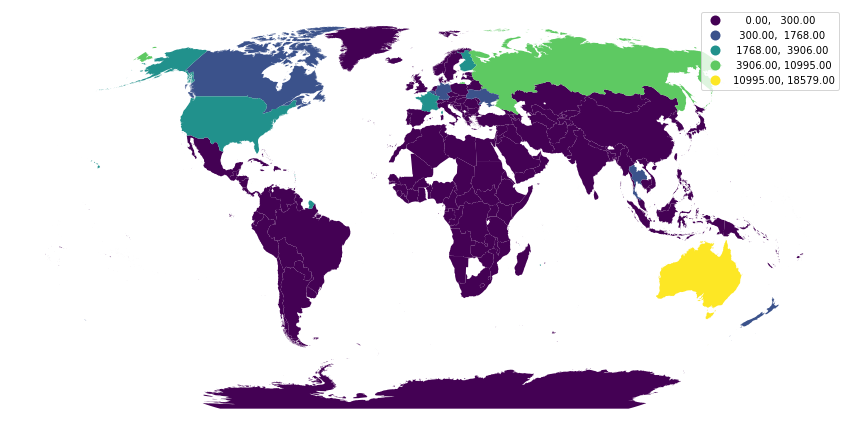

In [7]:
import geopandas
import cartopy

countries = geopandas.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)
gdf = geopandas.GeoDataFrame(
    countries.merge(species_per_country, left_on="ISO_A2", right_index=True)
)
crs = cartopy.crs.Robinson()
ax = gdf.to_crs(crs.proj4_init).plot(
    column="species", legend=True, scheme="natural_breaks", k=5, figsize=(15, 15)
)
ax.set_axis_off()

### Working with the full dataset

Thus far, we've just used a single partition from the full GBIF dataset. All of the examples shown in this notebook work on the entire dataset using `dask.dataframe` to read in the Parquet dataset.

You might want create a cluster to process the data in parallel on many machines.

```python
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
```

Then use `dask.dataframe.read_parquet` to read in the files. To speed things up even more, we'll specify a subset of files to read in.

```python
df = dd.read_parquet(
    signed_asset.href,
    columns=["countrycode", "species"],
    storage_options=signed_asset.extra_fields["table:storage_options"],
)
```

Now you can repeat the computations above, replacing `chunk` with `df`.

### Next Steps

Now that you've an introduction to the Forest Inventory and Analysis dataset, learn more with

* The [Reading tabular data quickstart](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-tabular-data/) for an introduction to tabular data on the Planeatry Computer
* [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask to work with large datasets